# Smallholder Forestry Example 
Requesting Planet's Carbon Monitoring dataset for small plots  

This notebook assumes that you have already registered and installed Cecil in your local environment.  The steps for doing this are located on [Cecil's Getting Started Page](https://docs.cecil.earth/Getting-started-111ef16bbbe48123aaa1d0a4bbd0a63d).

In [1]:
import pandas as pd
import geopandas as gpd

import plotly.express as px

import cecil


In [2]:
# Forest Carbon Monitoring
# https://docs.cecil.earth/Forest-carbon-monitoring-111ef16bbbe4817aa1a8dce6d9216665
# 3.5 m resolution
PLANET_DATASET_ID = '4d8bd6ba-b751-4c46-8e70-5000e6d8b212'
# Cost information for all datasets is available on Cecil's Pricing page
# https://docs.cecil.earth/Pricing-cf107b09599d4638b8f02fc863bd5961
PLANET_COST_PER_HA = 0.25  # USD

# Choose an Area of Interest

Each polygon's area in hectares and number of vertices


,area_ha,vertices
0,8.015337,657
1,0.472040,85
2,0.566890,89
3,1.763921,274
4,1.249553,170


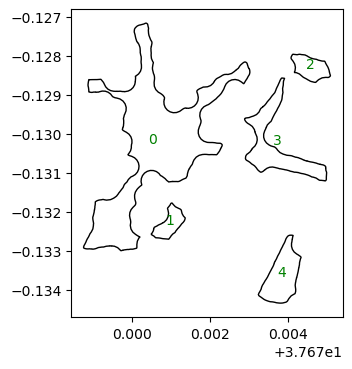

In [3]:
polygons = gpd.read_file('data/intermediate/example_polygons.gpkg', layer='example_polygons')

# Project to UTM zone 37N for accurate area calculation (e.g., UTM zone 37N for Kenya)
polygons_utm = polygons.to_crs(epsg=32637)

# Calculate total area in hectares
total_area_m2 = polygons_utm.geometry.area.sum()

# Calculate number of vertices for each polygon
# Note: This assumes polygons are valid and have an exterior ring
polygons['vertices'] = polygons.geometry.apply(lambda geom: len(geom.exterior.coords) if geom.is_valid else 0)
# Calculate total number of vertices
total_vertices = polygons['vertices'].sum()

# Use the UTM projection to calculate area in hectares
polygons['area_ha'] = polygons_utm.geometry.area / 10000 # 1 hectare = 10,000 m²
total_area_ha = polygons['area_ha'].sum()

print("Each polygon's area in hectares and number of vertices")
display(polygons[['area_ha', 'vertices']])

ax = polygons.plot(figsize=(4,4), edgecolor='black', facecolor='none')
for idx, row in polygons.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(str(idx), xy=(centroid.x, centroid.y), color='green', fontsize=10, ha='center')

# Check vertices count and calculate cost of request
AOI requests through Cecil for the Planet Monitoring Dataset should meet the following requirements:
* The CRS is EPSG:4326
* The total number of vertices per AOI is less than 1,500

The pricing for data requests can be found on [Cecil's Pricing page](https://docs.cecil.earth/Pricing-cf107b09599d4638b8f02fc863bd5961).

In this case, "Planet Forest Carbon Monitoring 3m" is $0.25/ha.



In [4]:
if polygons.crs != 'EPSG:4326':
    print(f'Warning: Polygons are in {polygons.crs}, but should be in EPSG:4326 for AOI requests through Cecil.')
else:
    print('Polygons are in EPSG:4326, suitable for AOI requests through Cecil.')

if total_vertices > 1500:
    print(f'Warning: Total number of vertices is {total_vertices}, which exceeds the limit of 1,500 for AOI requests for Planet Carbon Monitoring.')
else:
    print(f'Total number of vertices is {total_vertices}, which meets the Planet requirement of 1,500 vertices maximum.')

print("")
print(f'Total area of polygons: {total_area_ha:.2f} hectares')
print(f'Estimated cost of data request: ${total_area_ha * PLANET_COST_PER_HA:.2f} USD at ${PLANET_COST_PER_HA}/ha')


Polygons are in EPSG:4326, suitable for AOI requests through Cecil.
Total number of vertices is 1275, which meets the Planet requirement of 1,500 vertices maximum.

Total area of polygons: 12.07 hectares
Estimated cost of data request: $3.02 USD at $0.25/ha


# Start Cecil Client and Request Data

You need to have the Cecil SDK installed and configured in your environment. Make sure that you have set up your Cecil API key by running  
`export CECIL_API_KEY="your_api_key_here"`  
in the terminal where you are running your notebook.

In [5]:
# Initialize Cecil SDK
client = cecil.Client()

In [6]:
# Choose a label for your AOI that will help you identify it later
AOI_name = "5 Example Polygons"

#Cecil uses a geodict format, which we can obtain from the polygons geodataframe.
geodict = polygons.to_geo_dict()
geom = geodict['features'][0]['geometry']

aoi = client.create_aoi(
    name=AOI_name,
    geometry=geom
)
print(aoi)

id='244c0574-7e57-431d-90cf-877074fbed8c' name='5 Example Polygons' geometry={'type': 'Polygon', 'coordinates': [[[37.668758, -0.132887], [37.668772, -0.132855], [37.668774, -0.132851], [37.668788, -0.132828], [37.668797, -0.13281], [37.668812, -0.13278], [37.668824, -0.132753], [37.668829, -0.132737], [37.668831, -0.132733], [37.668831, -0.132733], [37.668837, -0.13272], [37.668845, -0.132705], [37.668854, -0.132686], [37.668883, -0.132641], [37.668914, -0.132575], [37.668919, -0.132561], [37.668954, -0.132514], [37.668994, -0.132436], [37.669008, -0.13235], [37.669008, -0.132331], [37.669013, -0.132293], [37.668997, -0.132207], [37.668996, -0.132203], [37.668993, -0.132167], [37.668993, -0.132167], [37.668992, -0.132161], [37.668993, -0.132132], [37.668999, -0.132114], [37.669002, -0.132107], [37.669028, -0.131999], [37.669029, -0.131975], [37.66903, -0.131972], [37.669037, -0.131947], [37.669035, -0.131947], [37.669046, -0.131884], [37.669046, -0.131858], [37.669054, -0.131817], [37

# Request data through Cecil for AOI
* This is the step that costs money. Make sure you're happy with your AOI and you know the size before you execute. :)  

* This data request wil populate the Snowflake Database on Cecil's side with your AOI data request.  

In [7]:
planet_data_request = client.create_data_request(
    aoi_id=aoi.id,
    dataset_id=PLANET_DATASET_ID,
)
print(planet_data_request)

id='4367dd1c-1bdb-4536-b3f7-b3e955eba848' aoi_id='244c0574-7e57-431d-90cf-877074fbed8c' dataset_id='4d8bd6ba-b751-4c46-8e70-5000e6d8b212' created_at=datetime.datetime(2025, 8, 14, 16, 33, 27, 504000, tzinfo=TzInfo(UTC)) created_by='72f22e31-16a4-448a-ad1c-64696d104a43'


# Query data from Cecil's database and pull into a pandas dataframe

* The data request in the previous step runs in the background on Cecil's database and may take up to a few hours to a few business days to fully populate.  

* Although you may be able to fetch the data immediately, it may not be the full dataset that is initially returned to you, as it may still be populating in Cecil's database. It's recommended to check back periodically if the dataset available has grown.

In [9]:
# Query the data request database on Cecil's side for the AOI data as a dataframe

df = client.query(f'''
             SELECT *, 
                ST_ASWKT(pixel_boundary) AS pixel_boundary_geom,  --transforms pixel_boundary to a polygon geometry
             FROM data_request_db.planet.forest_carbon_monitoring
             WHERE aoi_id = '{aoi.id}' 
             '''
)

df.head(2)

,aoi_id,data_request_id,crs,date,x,y,pixel_boundary,aboveground_live_carbon_density,aboveground_live_carbon_density_uncertainty_lower_bound,aboveground_live_carbon_density_uncertainty_upper_bound,canopy_cover,canopy_cover_uncertainty_lower_bound,canopy_cover_uncertainty_upper_bound,canopy_height,canopy_height_uncertainty_lower_bound,canopy_height_uncertainty_upper_bound,pixel_boundary_geom
0,244c0574-7e57-431d-90cf-877074fbed8c,4367dd1c-1bdb-4536-b3f7-b3e955eba848,EPSG:4326,2020-12-21,37.670213,-0.127213,"{\n ""coordinates"": [\n [\n [\n ...",42.0,7.0,109.0,46.0,0.0,96.0,8.0,0.0,15.0,"POLYGON((37.6702 -0.1272,37.6702 -0.127225,37...."
1,244c0574-7e57-431d-90cf-877074fbed8c,4367dd1c-1bdb-4536-b3f7-b3e955eba848,EPSG:4326,2020-12-21,37.670338,-0.127213,"{\n ""coordinates"": [\n [\n [\n ...",37.0,6.0,100.0,40.0,0.0,90.0,7.0,0.0,16.0,"POLYGON((37.670325 -0.1272,37.670325 -0.127225..."
